In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

import zipfile
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import copy
import tqdm
from PIL import Image

%matplotlib inline

In [2]:
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as train_z:
    train_z.extractall('/kaggle/working/')
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as test_z:
    test_z.extractall('/kaggle/working/')

In [3]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
class image_dataset(torch.utils.data.Dataset):
    def __init__(self, lst, dir, mode : str, transform = None):
        self.lst = lst
        self.dir = dir
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.lst[0]:
                self.label = 1
            else:
                self.label = 0
           
#             transforms_list = transforms.Compose([
#                 transforms.Resize((256, 256)),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomChoice([
#                     transforms.RandomResizedCrop(256),
#                     transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#                     transforms.RandomAffine(0, translate = (0.1, 0.1))
#                 ]),
#                 transforms.ToTensor(),
#                 transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
#                 transforms.Normalize(mean = [0.485, 0.456, 0.406],
#                                                  std = [0.229, 0.224, 0.225])
#             ])
            
#         else:
#             transforms_list = transforms.Compose([
#                 transforms.Resize((256, 256)),
#                 transforms.ToTensor(),
#                 transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
#                 transforms.Normalize(mean = [0.485, 0.456, 0.406],
#                                                  std = [0.229, 0.224, 0.225])
#             ])
            
    def __len__(self):
        return len(self.lst)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.dir, self.lst[index]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.lst[index]

        
data_train_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomResizedCrop(256),
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(0, translate = (0.1, 0.1))
                ]),
                transforms.ToTensor(),
                transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                 std = [0.229, 0.224, 0.225])    
])

data_test_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                 std = [0.229, 0.224, 0.225])    
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

In [5]:
## Creating a training dataset
cats = image_dataset(cat_files, train_dir, mode = 'train', transform = data_train_transform)
dogs = image_dataset(dog_files, train_dir, mode = 'train', transform = data_train_transform)
# , transform = data_transform
train_df = ConcatDataset([cats, dogs])

## Creating a test dataset
test_df = image_dataset(test_files, test_dir,mode = 'test', transform = data_test_transform)

In [6]:
# ## Splitting a training dataset into train and val dataset

# shuffle_dataset = True
# random_seed = 711
# validation_split = 0.15

# dataset_size = len(train_df)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))

# if shuffle_dataset:
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

In [7]:
## Data Loader
# train_dl = torch.utils.data.DataLoader(train_sampler, batch_size = 32, shuffle = True, num_workers = 4)
train_dl = torch.utils.data.DataLoader(train_df, batch_size = 32, shuffle = True, num_workers = 4)
# val_dl = torch.utils.data.DataLoader(val_sampler, batch_size = 32, shuffle = True, num_workers = 4)
test_dl = torch.utils.data.DataLoader(test_df, batch_size = 32, shuffle = False, num_workers = 4)

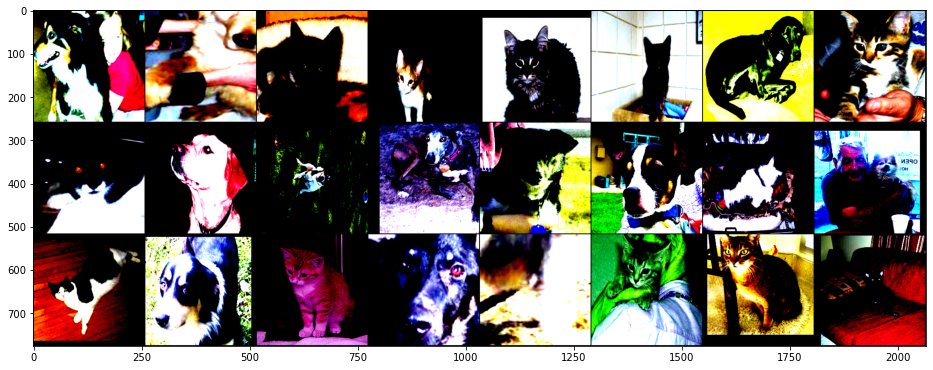

In [8]:
samples, labels = iter(train_dl).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [9]:
# device = 'cuda'

# model = torchvision.models.resnet18(pretrained = True)

In [10]:
!pip install efficientnet_pytorch
import efficientnet_pytorch

class effnet_model(nn.Module):
    def __init__(self, effnet_level, dropout):
        super(effnet_model, self).__init__()
        self.effnet_level = effnet_level
        self.effnet = efficientnet_pytorch.EfficientNet.from_pretrained(f'efficientnet-b{self.effnet_level}')
        self.dropout = nn.Dropout2d(dropout)
        self.fc1 = nn.Linear(in_features = 1000, out_features = 500)
        self.fc2 = nn.Linear(500, 2)
    
    def forward(self, X):
        out = self.effnet(X)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=93c3fcda4282b9f397f6c7f05ffc0ed20881199d5352e9055bcbeb802ec58ca8
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
effnet_level = 4
model = effnet_model(effnet_level = effnet_level, dropout = 0.3)
#model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR()
scheduler = CosineAnnealingLR(optimizer,T_max=5,eta_min=1e-6)

# cnf['optimizer'] = torch.optim.Adam(model.parameters(), lr=cnf['learning_rate'])

In [13]:
## Parameters
epochs = 5
itr = 1
p_itr = 200
total_loss = 0
loss_lst = []
acc_lst = []

[Epoch 1/5] Iteration 200 -> Train Loss: 0.2086, Accuracy: 0.938
[Epoch 1/5] Iteration 400 -> Train Loss: 0.1361, Accuracy: 0.969
[Epoch 1/5] Iteration 600 -> Train Loss: 0.1131, Accuracy: 0.969
[Epoch 2/5] Iteration 800 -> Train Loss: 0.1013, Accuracy: 0.938
[Epoch 2/5] Iteration 1000 -> Train Loss: 0.1077, Accuracy: 1.000
[Epoch 2/5] Iteration 1200 -> Train Loss: 0.0976, Accuracy: 0.906
[Epoch 2/5] Iteration 1400 -> Train Loss: 0.1393, Accuracy: 0.938
[Epoch 3/5] Iteration 1600 -> Train Loss: 0.1073, Accuracy: 1.000
[Epoch 3/5] Iteration 1800 -> Train Loss: 0.1175, Accuracy: 0.938
[Epoch 3/5] Iteration 2000 -> Train Loss: 0.1089, Accuracy: 0.938
[Epoch 3/5] Iteration 2200 -> Train Loss: 0.1064, Accuracy: 0.969
[Epoch 4/5] Iteration 2400 -> Train Loss: 0.0888, Accuracy: 1.000
[Epoch 4/5] Iteration 2600 -> Train Loss: 0.0901, Accuracy: 0.969
[Epoch 4/5] Iteration 2800 -> Train Loss: 0.0948, Accuracy: 0.844
[Epoch 4/5] Iteration 3000 -> Train Loss: 0.1002, Accuracy: 1.000
[Epoch 5/5] It

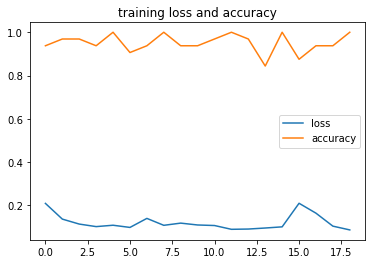

In [14]:
## Training Function

model.train()
for epoch in range(epochs):
    for inputs, targets in train_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim = 1)
            correct = pred.eq(targets)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch + 1, epochs, itr, total_loss/p_itr, acc))
            loss_lst.append(total_loss/p_itr)
            acc_lst.append(acc)
            total_loss = 0
        
        itr += 1
        
plt.plot(loss_lst, label = 'loss')
plt.plot(acc_lst, label = 'accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [15]:
filename_pth = 'effnetnet_catdog.pth'
torch.save(model.state_dict(), filename_pth)

In [16]:
model.eval()
fn_list = []
pred_list = []
for x, fn in test_dl:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('catdog_effnet_pred.csv', index=False)

In [17]:
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Sequential(
#         nn.Linear(num_ftrs, 500),
#         nn.Linear(500, 2)
# )

# model.to(device)

In [18]:
# # print(os.listdir('/kaggle/working/'))
# filenames = os.listdir('/kaggle/working/train')
# category = [i.split('.')[0] for i in filenames]
# print(filenames[0]), print(category[0])

# df_train = pd.DataFrame({'filenames': filenames, 'category': category})
# df_train['label'] = np.where(df_train['category'] == "dog", 1, 0)
# df_train.head()

In [19]:
# filenames = os.listdir('/kaggle/working/test1')

# print(filenames[0])
# df_test = pd.DataFrame({'filename': filenames})
# df_test.head()

In [20]:
# ## Splitting the train dataset into train & valid dataset
# x_train, x_val, y_train, y_val = train_test_split(df_train.drop(columns = 'label'))

In [21]:
# class image_dataset(torch.utils.data.Dataset):
#     def __init__(self, lst, dir, mode: str, transform):
#         self.lst = lst
#         self.dir = dir
#         self.mode = mode
#         self.transform = transform
#         if self.mode == 'train':
#             if 'dog' in self.lst[0]:
#                 self.label = 1
#             else:
#                 self.label = 0
                
#     def __len__(self):
#         return len(self.lst)
    
#     def __getitems__(self, index):
#         img = Image.open(os.path.join(self.dir, self.lst[index]))
#         if self.transform:
#             img = self.transform(img)
#         if self.mode = 'train':
#             img = img.numpy()
#             return img.astype('float32'), self.label
#         else:
#             img = img.numpy()
#             return img.astype('float32'), self.lst[index]
        
# transforms_list = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomChoice([
#         transforms.RandomResizedCrop(256),
#         transfroms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#         transforms.RandomAffine(0, translate = (0.1, 0.1))
#     ]),
#     transforms.ToTensor(),
#     transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
#     transform.Normalize(mean = [0.485, 0.456, 0.406],
#                                      std = [0.229, 0.224, 0.225])
# ])

# cat_files = [tf for tf in train_files if 'cat' in tf]
# dog_files = [tf for tf in train_files if 'dog' in tf]

In [22]:
# class image_dataset(torch.utils.data.Dataset):
#     def __init__(self, mode:str, dataframe: pd.DataFrame, img_size:int):
#         super(image_dataset, self).__init__()
#         self.mode = mode
#         self.df = dataframe
#         self.img_size = img_size
        
#         if self.mode == "train":
#             transform_list = [
#                 transforms.Resize((img_size, img_size)),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomChoice([
#                     transforms.RandomResizedCrop(img_size),
#                     transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#                     transforms.RandomAffine(0, translate=(0.1, 0.1))
#                 ]),
#                 transforms.ToTensor(),
#                 transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
#                 transforms.Normalize(mean = [0.485, 0.456, 0.406],
#                                      std = [0.229, 0.224, 0.225])
#             ]
#         else:
#             transforms_list = [
#                 transforms.Resize((img_size, img_size)),
#                 transforms.ToTensor(),
#                 transforms.Lambda(lambda img: torch.cat((img, img, img), axis = 0) if img.shape[0] == 1 else img),
#                 transforms.Normalize(mean = [0.485, 0.456, 0.406],
#                                      std = [0.229, 0.224, 0.225])
#             ]
        
#         self.transforms = transforms.Compose(transforms_list)
        
#     def __getitems__(self, index):
#         image_id = self.df.iloc[index].file_name
#         location = self.df.iloc[index].folder
#         image = Image.open(f'{location}/{image_id}')
#         image = self.transforms(image)
#         if self.mode == 'train' or self.mode == 'val':
#             target = self.df.iloc[index].target
#             return {'image': image, 'target': target}
#         else:
#             return {'image': image}
        
#     def __len__(self) -> int:
#         return self.df.shape[0]        

In [23]:
# ## Data Loader

# batch_size = 255

# train_loader = torch.utils.data.DataLoader(dataset = df_train, batch_size = batch_size,  shuffle = True)
# test_loader = torch.utils.data.DataLoader(dataset = df_test, batch_size = batch_size, shuffle = False)

In [24]:
# import torchvision.transforms as transforms

# data_transformer = transform.Compose([transforms.ToTensor()])

# transformer_train = torchvision.transforms.Compose([
#     transform.RandomCrop(32, padding = 4),
#     torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#     torchvision.transforms.RandomAffine(0, translate-(0.1, 0.1)),
#     transforms.ToTensor()
# ])

